In [1]:
from pyqubo import Array,Constraint,Placeholder
from matplotlib import pyplot as plt
import networkx as nx
import random

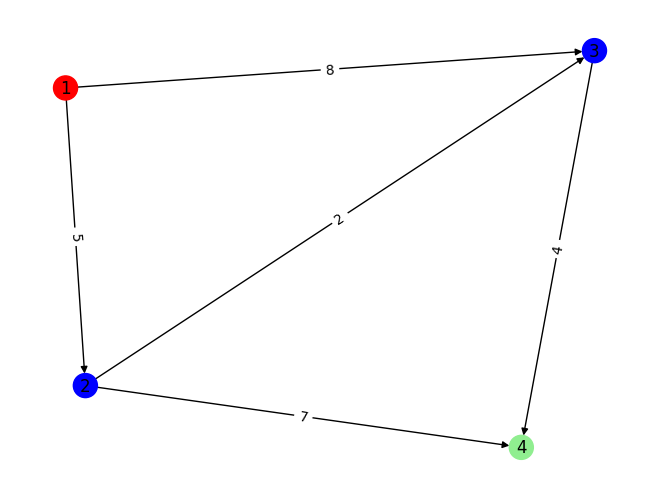

The most efficient path from 1 to 4 is: [1, 2, 3, 4]
The length of the path is: 11


In [2]:
edges = [(1,2),(1,3),(2,3),(2,4),(3,4)]
weights = [5,8,2,7,4]
source = 1
destination = 4
nodes = 4 # nodes = G.number_of_nodes()
def create_directed_graph(edges, weights, source, destination):
    if len(edges) != len(weights):
        raise ValueError("Edges and weights lists must have the same length.")

    # Create a directed graph
    G = nx.DiGraph()

    # Add edges with weights
    for i in range(len(edges)):
        G.add_edge(*edges[i], weight=weights[i])

    # Define colors for nodes
    node_colors = {node: 'red' if node == source else ('lightgreen' if node == destination else 'blue') for node in G.nodes}

    # Draw the graph
    pos = nx.spring_layout(G, seed=random.randint(1, 100))  # You can change the layout algorithm
    labels = nx.get_edge_attributes(G, 'weight') 
    nx.draw(G, pos, with_labels=True, node_color=[node_colors[node] for node in G.nodes])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()

    # Find the most efficient path using Dijkstra's algorithm
    shortest_path = nx.dijkstra_path(G, source=source, target=destination, weight='weight')
    shortest_path_length = nx.dijkstra_path_length(G, source=source, target=destination, weight='weight')

    print(f"The most efficient path from {source} to {destination} is: {shortest_path}")
    print(f"The length of the path is: {shortest_path_length}")

create_directed_graph(edges, weights, source, destination)

In [3]:
from pyqubo import Array,Constraint,Placeholder
x = Array.create(name = 'x', shape =len(edges), vartype = 'BINARY')
print(x)

Array([Binary('x[0]'), Binary('x[1]'), Binary('x[2]'), Binary('x[3]'), Binary('x[4]')])


In [4]:
i = 0
fcost = 0
for i in range(len(edges)):
    fcost += (weights[i]*x[i]) ## Put the expression for constraints in

p = 27
node=1
while(node<=nodes):
    sum = 0
    for j in range(len(edges)):
        if edges[j][0] == node: ##Outgoing from the current node
            sum += x[j]
        elif edges[j][1] == node: ##Incoming into the current node
            sum -= x[j]

    if node == source:
        sum -= 1
    elif node== destination:
        sum += 1

    fcost += p*((sum)**2)
    node+=1

print(fcost)

((27.000000 * ((1.000000 + (-1.000000 * Binary('x[4]')) + 0.000000 + (-1.000000 * Binary('x[3]'))) * (1.000000 + (-1.000000 * Binary('x[4]')) + 0.000000 + (-1.000000 * Binary('x[3]'))))) + (27.000000 * ((Binary('x[4]') + (-1.000000 * Binary('x[2]')) + 0.000000 + (-1.000000 * Binary('x[1]'))) * (Binary('x[4]') + (-1.000000 * Binary('x[2]')) + 0.000000 + (-1.000000 * Binary('x[1]'))))) + (27.000000 * ((Binary('x[3]') + Binary('x[2]') + 0.000000 + (-1.000000 * Binary('x[0]'))) * (Binary('x[3]') + Binary('x[2]') + 0.000000 + (-1.000000 * Binary('x[0]'))))) + (27.000000 * ((-1.000000 + Binary('x[1]') + 0.000000 + Binary('x[0]')) * (-1.000000 + Binary('x[1]') + 0.000000 + Binary('x[0]')))) + (4.000000 * Binary('x[4]')) + (7.000000 * Binary('x[3]')) + (2.000000 * Binary('x[2]')) + (8.000000 * Binary('x[1]')) + 0.000000 + (5.000000 * Binary('x[0]')))


In [5]:
model = fcost.compile()
print(model.to_qubo())

({('x[4]', 'x[1]'): -54.0, ('x[0]', 'x[0]'): 5.0, ('x[2]', 'x[2]'): 56.0, ('x[4]', 'x[2]'): -54.0, ('x[3]', 'x[2]'): 54.0, ('x[3]', 'x[3]'): 7.0, ('x[1]', 'x[0]'): 54.0, ('x[2]', 'x[1]'): 54.0, ('x[4]', 'x[3]'): 54.0, ('x[3]', 'x[0]'): -54.0, ('x[2]', 'x[0]'): -54.0, ('x[4]', 'x[4]'): 4.0, ('x[1]', 'x[1]'): 8.0}, 54.0)


In [6]:
linear, quadratic, offset = model.to_ising()
print("LINEAR:",linear,"QUADRATIC:",quadratic,"OFFSET:",offset)

LINEAR: {'x[0]': -11.0, 'x[1]': 17.5, 'x[2]': 28.0, 'x[3]': 17.0, 'x[4]': -11.5} QUADRATIC: {('x[0]', 'x[1]'): 13.5, ('x[0]', 'x[2]'): -13.5, ('x[2]', 'x[3]'): 13.5, ('x[0]', 'x[3]'): -13.5, ('x[2]', 'x[4]'): -13.5, ('x[3]', 'x[4]'): 13.5, ('x[1]', 'x[2]'): 13.5, ('x[1]', 'x[4]'): -13.5} OFFSET: 94.0


In [7]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
get_ipython().run_line_magic('matplotlib', 'inline')
import string
import time

# AWS imports: Import Braket SDK modules
import braket
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

In [8]:
def create_circuit(beta, gamma):
    ## initializing the initial qubit state with H gates ##
    circuit = Circuit()
    n_qubits = len(edges)

    for qubit in range(n_qubits):
        circuit.h(qubit)

    ## Implementing the problem Hamiltonian ##
    for qubit in range(n_qubits):
        linear_coeff = linear.get('x['+str(qubit)+']')
        circuit = circuit.rz(qubit, -1*linear_coeff)

    #Algorithmic method to add the ZZ gates - CHECK TO SEE IF IT AFFECTS THE RESULTS(it should'nt because they commute)
    for i in range(len(quadratic)):
        qubit_1 = int(list(quadratic.keys())[i][0][2])
        qubit_2 = int(list(quadratic.keys())[i][1][2])
        key = ('x[' + str(qubit_1) + ']', 'x[' + str(qubit_2) + ']')
    
        # Check if the key exists in the dictionary
        if key in quadratic:
            quadratic_coeff = quadratic[key]
            # The Ising-Coupling Gate
            #circuit.zz(qubit_1, qubit_2, quadratic_coeff*gamma)
            circuit.cnot(control=qubit_1, target=qubit_2)
            circuit.rz(qubit_2, quadratic_coeff*gamma)
            circuit.cnot(control=qubit_1, target=qubit_2)
    ## Implementing the Mixer Hamiltonian ##
    for qubit in range(n_qubits):
        circuit.rx(qubit, 2*beta) # theta=2*beta because rx rotates the qubit about X by theta/2 angle

    return circuit

<b>Remember that there are 3 parameters that can be varied - beta, gamma and penalty p </b>

In [9]:
## Expectation value of the Hamiltonian is basically the expected cost value which we can get from an average of the
## cost values over all states that have occurred ##
def compute_expectation(counts, shots):

    expectation = 0
    sum = 0
    states = list(counts.keys())
    for i in range(len(states)):
        state = states[i] # string variable of the current qubit states
        state_cost = 0
        for j in range(len(state)): # Convention of the states is that the left-most qubit is the first qubit q0
            state_cost = state_cost + int(state[j])*weights[j]

        expectation = expectation + state_cost*counts.get(state)

    expectation /= 10000
    return expectation

In [10]:
## Now we measure the circuit ##
def expectation_execute_circuit(param):
    ## Set up the device to run the circuit
    device = LocalSimulator()

    ## QAOA parameters to be optimized such that the eigenvalue Cost(β, γ) can be minimized ##
    beta = param[0]
    gamma = param[1]

    circuit = create_circuit(beta, gamma)

    shots = 10000
    result = device.run(circuit, shots).result()
    counts = result.measurement_counts

    return compute_expectation(counts, shots)

In [11]:
from scipy.optimize import minimize

res = minimize(expectation_execute_circuit,[1.0, 1.0],method='COBYLA')

## Analyzing the Results
beta = res.get('x')[0]
gamma = res.get('x')[1]
circuit = create_circuit(beta, gamma)
print(res,circuit)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 11.4079
       x: [ 1.263e+00  9.355e-01]
    nfev: 32
   maxcv: 0.0 T  : |0|    1     |2|    3    |4|5|    6     |7|8|    9    |10|11 |    12    |13 |   14   |   15    |16|    17    |    18    |19|   20   |
                                                                                                                                          
q0 : -H-Rz(11.00)--C-----------C-C------------C----------------C--------------C---Rx(2.53)------------------------------------------------
                   |           | |            |                |              |                                                           
q1 : -H-Rz(-17.50)-X-Rz(12.63)-X-|------------|----------------|--------------|---C------------------C--C---------------------C--Rx(2.53)-
                                 |            |                |              |   |                  |  |                     |           
q2 : -H-Rz(-

In [12]:
device = LocalSimulator()
result = device.run(circuit, shots = 10000).result()
counts = result.measurement_counts

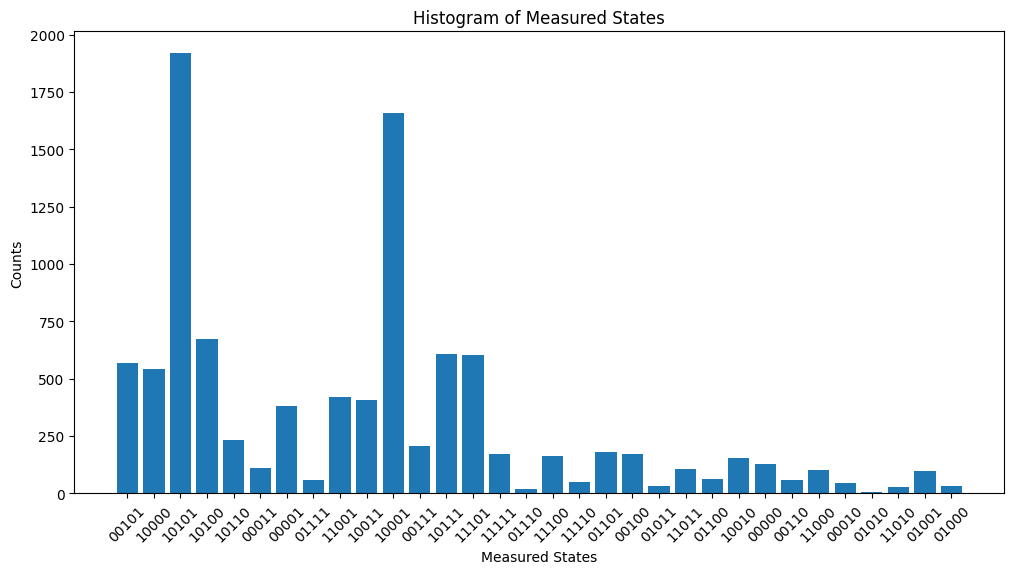

In [13]:
beta = res.get('x')[0]
gamma = res.get('x')[1]
braket_circuit = create_circuit(beta, gamma)

device = LocalSimulator()
result = device.run(circuit, shots = 10000).result()
counts = result.measurement_counts

#print(counts.keys())
#len(counts.keys())
# plot using Counter
#plt.bar(counts.keys(), counts.values())
#plt.xlabel('bitstrings')
#plt.ylabel('counts')

# Plot the histogram of the results
plt.figure(figsize=(12, 6))  # Adjust the width and height as needed
plt.bar(counts.keys(), counts.values())
plt.xlabel('Measured States')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotate the x-axis labels by 45 degrees
plt.title('Histogram of Measured States')
plt.show()

# Post Processing #

In [14]:
def check_state(s):
    ## Firstly check if the path starts from a source and ends at a destination
    source_flag = False
    destination_flag = False
    multiple_branches = False
    continuity_flag = True

    starting_nodes = []
    ending_nodes = []

    ## Check to see if the source and destination nodes exist in the network
    i=0
    for i in range(len(s)):
        if(s[i] == '1'):

            if(edges[i][0] == source):
                source_flag = True
            if(edges[i][1] == destination):
                destination_flag = True

            starting_nodes += [edges[i][0]]
            ending_nodes += [edges[i][1]]
    ## Now check if a node repeats itself in starting or ending_nodes. If yes, set multiple_branches
    i = 0
    for i in range(len(starting_nodes)):
        cnt1 = starting_nodes.count(starting_nodes[i])
        cnt2 = ending_nodes.count(ending_nodes[i])
        if cnt1 > 1 or cnt2 > 1:
            multiple_branches = True
            break
    ## Then iteratively go through ending nodes and check if the same node exists in the next starting_nodes index                
    ## This is an easier check for continuity and necessarily requires the edges nodes to be in some order
    ## Also go with the thumb rule that the destination node will be the last value of ending_nodes
    for i in range(len(ending_nodes)-1):
        if starting_nodes[i+1] != ending_nodes[i]:
            continuity_flag = False
            break
    if source_flag and destination_flag and continuity_flag and (not multiple_branches):
        return True
    else:
        return False
        
states = list(counts.keys())
possible_states = []
i = 0
for i in range(len(states)):
    s = states[i]
    flag = check_state(s)
    if flag:
        possible_states += [s]
del states
print(possible_states)

['10101', '10010', '01001']


## Possible States Amplification Using Grover's Search Algorithm ##
Here we are going to implement Grover's Algorithm to amplify the amplitudes of the possible states taken from the post processing

In [15]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
#from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
#service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

from qiskit import *
import math
import matplotlib.pyplot as plt

In [16]:
# Define the list of paths
paths = [
    '10011', '01001', '10100', '00001', '10101', '11000', '10111', '00101',
    '11101', '10001', '10000', '00000', '11010', '00011', '11011', '11001',
    '01000', '10110', '10010', '11111', '11100', '00100', '01101', '00111',
    '11110', '00110', '00010', '01100', '01010', '01011', '01111', '01110']

# Define the target state
target_states = possible_states #['10101', '10010', '01001']

# Determine the number of qubits required
num_qubits = len(target_states[0])

In [17]:
def create_oracle(target_state, identifier):
    n = len(target_state)
    oracle = QuantumCircuit(n)

    # Apply X-gates to prepare the target_state (bit-flip oracle)
    for i, bit in enumerate(target_state):
        if bit == '0':
            oracle.x(i)

    # Apply a multi-controlled Z-gate (phase inversion)
    oracle.h(n-1)
    oracle.mct(list(range(n-1)), n-1)  # Multi-Control Toffoli
    oracle.h(n-1)

    # Uncompute the X-gates
    for i, bit in enumerate(target_state):
        if bit == '0':
            oracle.x(i)

    # Convert to a gate and name it with the identifier
    oracle_gate = oracle.to_gate()
    oracle_gate.name = "Oracle-" + identifier
    return oracle_gate

def prepare_oracles(target_states):
    oracles = []
    for i, target_state in enumerate(target_states):
        oracle_gate = create_oracle(target_state, target_states[i])
        oracles.append(oracle_gate)
    return oracles

oracle_gates = prepare_oracles(target_states)

In [18]:
def create_grover_diffusion(n):
    grover_diffusion = QuantumCircuit(n)

    # Apply H-gates to all qubits
    grover_diffusion.h(range(n))

    # Apply multi-controlled Z-gate (inversion about the mean)
    grover_diffusion.x(range(n))
    grover_diffusion.h(n-1)
    grover_diffusion.mct(list(range(n-1)), n-1)
    grover_diffusion.h(n-1)
    grover_diffusion.x(range(n))

    # Convert to a gate
    grover_diffusion_gate = grover_diffusion.to_gate()
    grover_diffusion_gate.name = "Diffusion"
    return grover_diffusion_gate

grover_diffusion_gate = create_grover_diffusion(num_qubits)

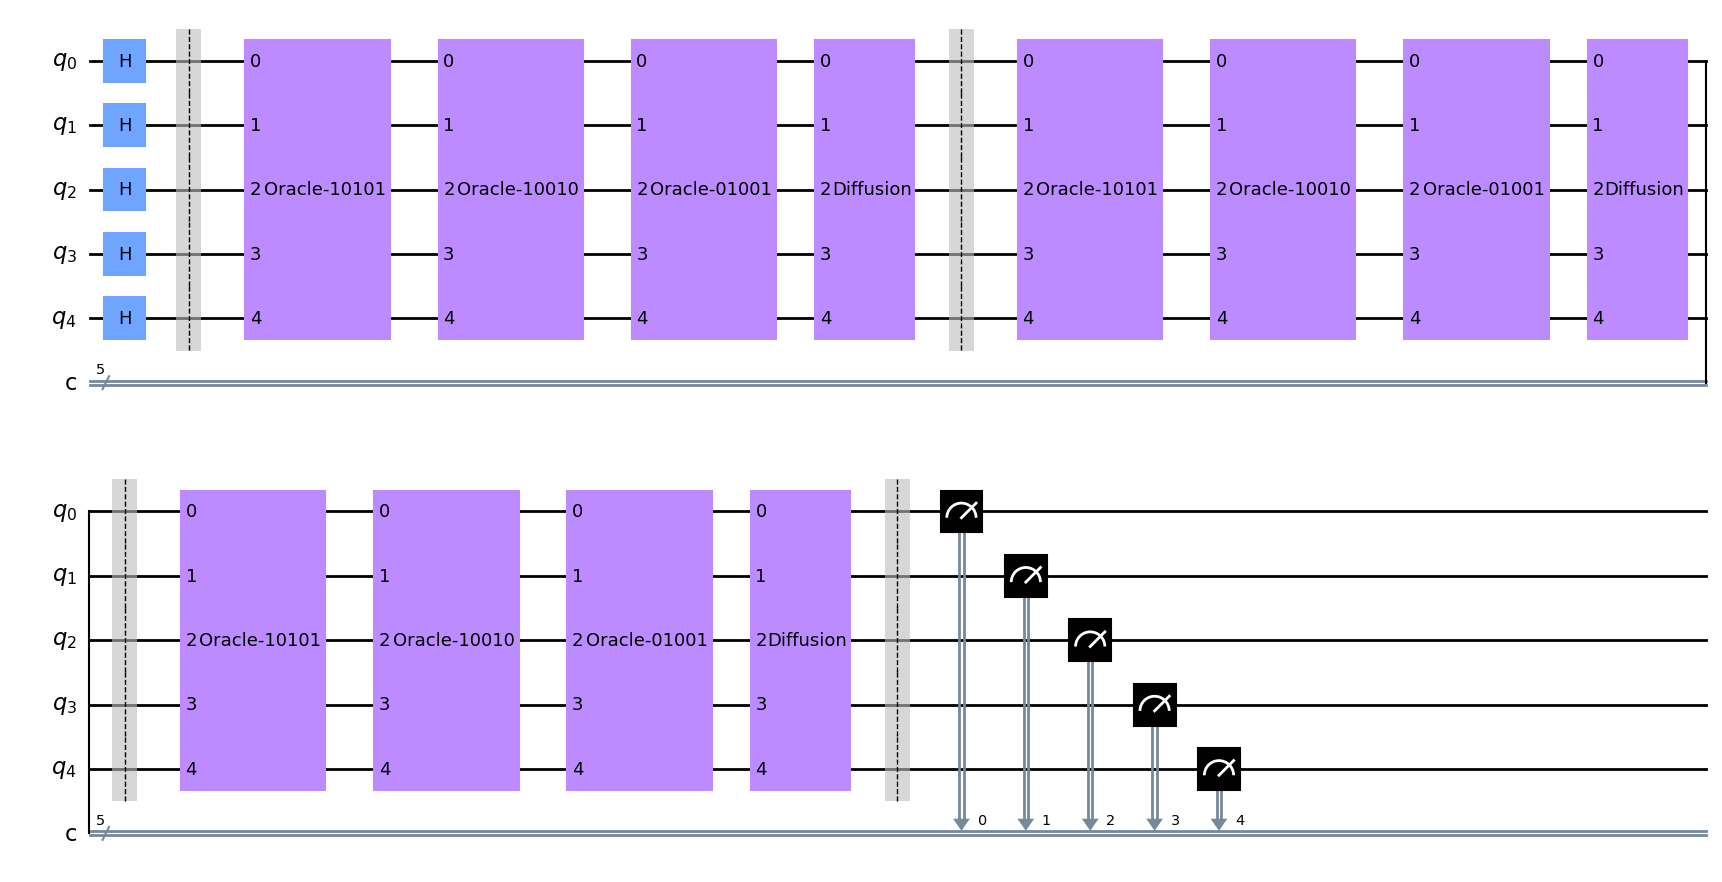

In [22]:
# Create a quantum circuit with the necessary qubits
grover_circuit = QuantumCircuit(num_qubits, num_qubits)

# Step 1: Initialize the superposition of states
grover_circuit.h(range(num_qubits))
grover_circuit.barrier()

# Step 2: Define the number of Grover iterations
num_iterations = 3  # Adjust as needed

# Step 3: Perform Grover iterations
for _ in range(num_iterations):
    # Append the oracle gates to the grover_circuit
    for oracle_gate in oracle_gates:
        grover_circuit.append(oracle_gate, range(len(target_states[0])))
    grover_circuit.append(grover_diffusion_gate, range(num_qubits))
    grover_circuit.barrier()

# Step 4: Measure the qubits
grover_circuit.measure(range(num_qubits), range(num_qubits))

grover_circuit.draw("mpl")

In [23]:
# Simulate the circuit
simulator = Aer.get_backend('qasm_simulator')
job = execute(grover_circuit, simulator, shots=1024*100)
result = job.result()
counts = result.get_counts()

{'01101': 7180, '10101': 30492, '00101': 1985, '11011': 7296, '00011': 3087, '10110': 7353, '00000': 13292, '00010': 2019, '11000': 3027, '01001': 4269, '11110': 1977, '10010': 4165, '01110': 2987, '00001': 234, '11111': 657, '11001': 1998, '10100': 2024, '10011': 2039, '01111': 1971, '01000': 2063, '10111': 217, '10000': 243, '00100': 598, '01011': 274, '11101': 221, '00110': 226, '01100': 214, '11010': 195, '10001': 25, '11100': 19, '01010': 27, '00111': 26}
Most likely state: 10101


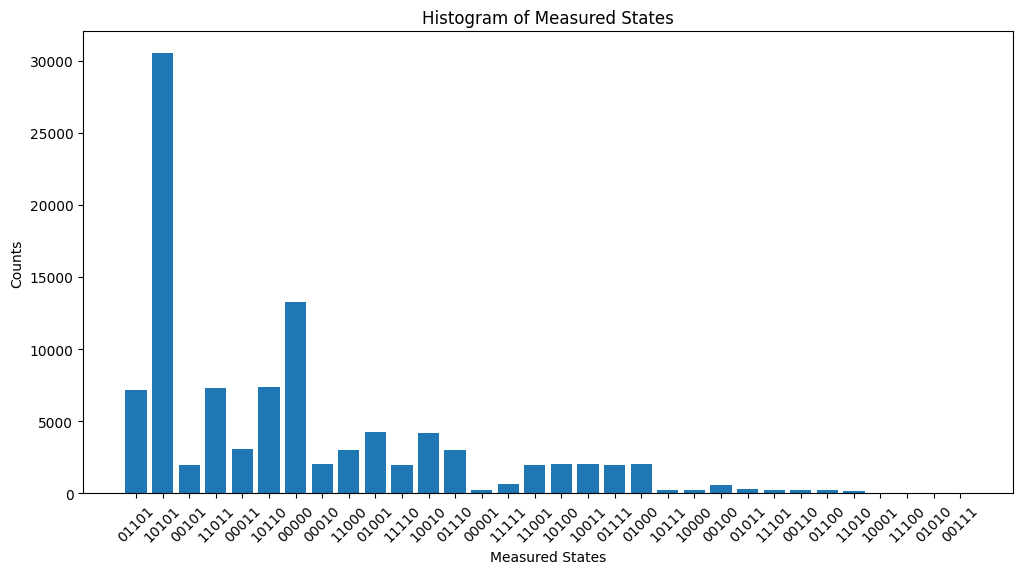

In [24]:
# Print the measurement results
print(counts)

# Find the state with the highest probability
max_state = max(counts, key=counts.get)
# Print the results
print("Most likely state:", max_state)

# Plot the histogram of the results
plt.figure(figsize=(12, 6))  # Adjust the width and height as needed
plt.bar(counts.keys(), counts.values())
plt.xlabel('Measured States')
plt.ylabel('Counts')
plt.xticks(rotation=45)  # Rotate the x-axis labels by 45 degrees
plt.title('Histogram of Measured States')
plt.show()

### The Cost of Calculated Optimized Path

In [113]:
# The cost of the optimized Path:
count_states = []
for state in possible_states:
    if state in counts:
        count_states.append(str(counts[state]))
    else:
        count_states.append('0')  # Use 0 if the state is not in counts
    
dict_states = dict(zip(possible_states, count_states))
    
if dict_states:
    max_state = max(dict_states, key=lambda x: int(dict_states[x]))
    cost_opt = np.sum(np.multiply([int(char) for char in max_state], weights))
else:
    cost_opt = 0  # Handle the case where dict_states is empty

print(cost_opt)

11


## Experimenting with Penalty Strength p ##
first we are modularizing the code and we will be making use of probablity of optimized path to benchmark the expt

In [114]:
def Static_Model(G, edges, weights, source, destination, nodes, p):
    
    x = Array.create(name = 'x', shape =len(edges), vartype = 'BINARY') 

    i = 0
    fcost = 0
    for i in range(len(edges)):
        fcost += (weights[i]*x[i]) ## Put the expression for constraints in
    node=1
    while(node<=nodes):
        sum = 0
        for j in range(len(edges)):
            if edges[j][0] == node: ##Outgoing from the current node
                sum += x[j]
            elif edges[j][1] == node: ##Incoming into the current node
                sum -= x[j]

        if node == source:
            sum -= 1
        elif node== destination:
            sum += 1

        fcost += p*((sum)**2)
        node+=1
    model = fcost.compile()
    linear, quadratic, offset = model.to_ising()

    ## Now we create the circuit ##
    #print("QAOA starts here")
    def create_circuit(beta, gamma):
        ## initializing the initial qubit state with H gates ##
        circuit = Circuit()
        n_qubits = len(edges)

        for qubit in range(n_qubits):
            circuit.h(qubit)

        ## Implementing the problem Hamiltonian ##
        for qubit in range(n_qubits):
            linear_coeff = linear.get('x['+str(qubit)+']')
            circuit = circuit.rz(qubit, -1*linear_coeff)

        #Algorithmic method to add the ZZ gates - CHECK TO SEE IF IT AFFECTS THE RESULTS(it should'nt because they commute)
        for i in range(len(quadratic)):
            qubit_1 = int(list(quadratic.keys())[i][0][2])
            qubit_2 = int(list(quadratic.keys())[i][1][2])
            key = ('x[' + str(qubit_1) + ']', 'x[' + str(qubit_2) + ']')
        
            # Check if the key exists in the dictionary
            if key in quadratic:
                quadratic_coeff = quadratic[key]
                # The Ising-Coupling Gate
                #circuit.zz(qubit_1, qubit_2, quadratic_coeff*gamma)
                circuit.cnot(control=qubit_1, target=qubit_2)
                circuit.rz(qubit_2, quadratic_coeff*gamma)
                circuit.cnot(control=qubit_1, target=qubit_2)
                
        ## Implementing the Mixer Hamiltonian ##
        for qubit in range(n_qubits):
            circuit.rx(qubit, 2*beta) # theta=2*beta because rx rotates the qubit about X by theta/2 angle

        return circuit


    # * <b>Remember that there are 3 parameters that can be varied - beta, gamma and penalty p </b>

    # In[29]:


    ## Expectation value of the Hamiltonian is basically the expected cost value which we can get from an average of the
    ## cost values over all states that have occurred ##
    def compute_expectation(counts, shots):

        expectation = 0
        sum = 0
        states = list(counts.keys())
        for i in range(len(states)):
            state = states[i] # string variable of the current qubit states
            state_cost = 0
            for j in range(len(state)): # Convention of the states is that the left-most qubit is the first qubit q0
                state_cost = state_cost + int(state[j])*weights[j]

            expectation = expectation + state_cost*counts.get(state)

        expectation /= 10000
        return expectation


    # In[30]:


    ## Now we measure the circuit ##
    def expectation_execute_circuit(param):
        ## Set up the device to run the circuit
        device = LocalSimulator()
        #device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
        
        ## QAOA parameters to be optimized such that the eigenvalue Cost(β, γ) can be minimized ##
        beta = param[0]
        gamma = param[1]

        circuit = create_circuit(beta, gamma)

        shots = 10000
        result = device.run(circuit, shots = 10000).result()
        counts = result.measurement_counts

        return compute_expectation(counts, shots)    

    #print("optimization starts here")
    res = minimize(expectation_execute_circuit,
                   [1.0, 1.0],
                   method='COBYLA')

    # ## Analyzing the Results
    beta = res.get('x')[0]
    gamma = res.get('x')[1]
    circuit = create_circuit(beta, gamma)

    device = LocalSimulator()
    #device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
    
    result = device.run(circuit, shots = 10000).result()
    counts = result.measurement_counts
    #print("optimization ends here")

    # plot using Counter
    #plt.bar(counts.keys(), counts.values())
    #plt.xlabel('bitstrings')
    #plt.ylabel('counts')


    # ## Post-Processing
    # 
    # Remove the output states that are not possible (among the top ten most probable states) and then check for the most probable states.
    # Check for joined paths, that is check that if a path enum ending with a number exists, then another path enum starting with the same number also exists, unless its a source or destination. They should always be 1.
    #print("QAOA ends here")
    def check_state(s):

        ## Firstly check if the path starts from a source and ends at a destination
        source_flag = False
        destination_flag = False
        multiple_branches = False
        continuity_flag = True

        starting_nodes = []
        ending_nodes = []

        ## Check to see if the source and destination nodes exist in the network
        i=0
        for i in range(len(s)):
            if(s[i] == '1'):

                if(edges[i][0] == source):
                    source_flag = True
                if(edges[i][1] == destination):
                    destination_flag = True

                starting_nodes += [edges[i][0]]
                ending_nodes += [edges[i][1]]

        ## Now check if a node repeats itself in starting or ending_nodes. If yes, set multiple_branches
        i = 0
        for i in range(len(starting_nodes)):
            cnt1 = starting_nodes.count(starting_nodes[i])
            cnt2 = ending_nodes.count(ending_nodes[i])
            if cnt1 > 1 or cnt2 > 1:
                multiple_branches = True
                break
        ## Then iteratively go through ending nodes and check if the same node exists in the next starting_nodes index                
        ## This is an easier check for continuity and necessarily requires the edges nodes to be in some order
        ## Also go with the thumb rule that the destination node will be the last value of ending_nodes
        for i in range(len(ending_nodes)-1):
            if starting_nodes[i+1] != ending_nodes[i]:
                continuity_flag = False
                break
        if source_flag and destination_flag and continuity_flag and (not multiple_branches):
            return True
        else:
            return False

    states = list(counts.keys())
    possible_states = []
    i = 0
    for i in range(len(states)):
        s = states[i]
        flag = check_state(s)
        if flag:
            possible_states += [s]
    del states
    
    # The cost of the optimized Path:
    count_states = []
    for state in possible_states:
        if state in counts:
            count_states.append(str(counts[state]))
        else:
            count_states.append('0')  # Use 0 if the state is not in counts
    
    dict_states = dict(zip(possible_states, count_states))
    
    if dict_states:
        #Find the maximum value
        max_state = max(dict_states, key=lambda x: int(dict_states[x]))
        max_count = dict_states[max_state]
        
        # Remove the maximum from the dictionary
        del dict_states[max_state]

        # Find the second maximum value
        '''
        second_max_state = max(dict_states, key=lambda x: int(dict_states[x]))
        second_max_count = dict_states[second_max_state]
        '''
        cost_opt = np.sum(np.multiply([int(char) for char in max_state], weights))
    else:
        cost_opt = 0  # Handle the case where dict_states is empty
    
    return [max_state, max_count]

### Testing 1: Compare the probablities of most optimized path with penalty strength p

In [83]:
edges = [(1,2), (1,3), (2,4), (3,5), (4,6), (5,7), (6,8), (7,8)]
weights = [5,1,5,3,1,6,1,4]
G = nx.DiGraph()
for i in range(len(edges)):
    G.add_edge(edges[i][0],edges[i][1],weight=weights[i])
## Set the source and destination nodes ##
source = 1
destination = 8
nodes = G.number_of_nodes()

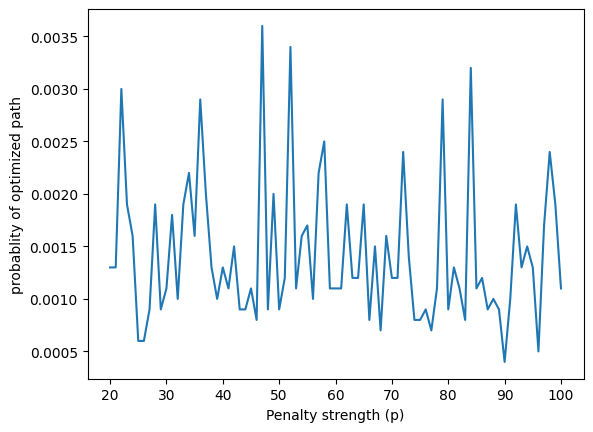

{20: 0.0013, 21: 0.0013, 22: 0.003, 23: 0.0019, 24: 0.0016, 25: 0.0006, 26: 0.0006, 27: 0.0009, 28: 0.0019, 29: 0.0009, 30: 0.0011, 31: 0.0018, 32: 0.001, 33: 0.0019, 34: 0.0022, 35: 0.0016, 36: 0.0029, 37: 0.002, 38: 0.0013, 39: 0.001, 40: 0.0013, 41: 0.0011, 42: 0.0015, 43: 0.0009, 44: 0.0009, 45: 0.0011, 46: 0.0008, 47: 0.0036, 48: 0.0009, 49: 0.002, 50: 0.0009, 51: 0.0012, 52: 0.0034, 53: 0.0011, 54: 0.0016, 55: 0.0017, 56: 0.001, 57: 0.0022, 58: 0.0025, 59: 0.0011, 60: 0.0011, 61: 0.0011, 62: 0.0019, 63: 0.0012, 64: 0.0012, 65: 0.0019, 66: 0.0008, 67: 0.0015, 68: 0.0007, 69: 0.0016, 70: 0.0012, 71: 0.0012, 72: 0.0024, 73: 0.0014, 74: 0.0008, 75: 0.0008, 76: 0.0009, 77: 0.0007, 78: 0.0011, 79: 0.0029, 80: 0.0009, 81: 0.0013, 82: 0.0011, 83: 0.0008, 84: 0.0032, 85: 0.0011, 86: 0.0012, 87: 0.0009, 88: 0.001, 89: 0.0009, 90: 0.0004, 91: 0.001, 92: 0.0019, 93: 0.0013, 94: 0.0015, 95: 0.0013, 96: 0.0005, 97: 0.0017, 98: 0.0024, 99: 0.0019, 100: 0.0011}


In [84]:
p_min, p_max = 20, 100
def test1(G, edges, weights, source, destination, nodes, p_min, p_max):
    p_array = list(range(p_min,p_max+1))
    max_count_array = []
    for p in p_array:
        max_count_string = Static_Model(G, edges, weights, source, destination, nodes, p)[1]
        max_count = int(max_count_string)
        max_count_array.append(max_count/10000)
    plt.plot(p_array, max_count_array,)
    plt.xlabel('Penalty strength (p)')
    plt.ylabel('probablity of optimized path')
    plt.show()
    result_dict = {}
    for i in range(len(p_array)):
        result_dict[p_array[i]] = max_count_array[i]
    return result_dict
result_dict = test1(G, edges, weights, source, destination, nodes, p_min, p_max)
print(result_dict)

### Testing 2: difference between the probabilities of most optimized path and sub-optimal path

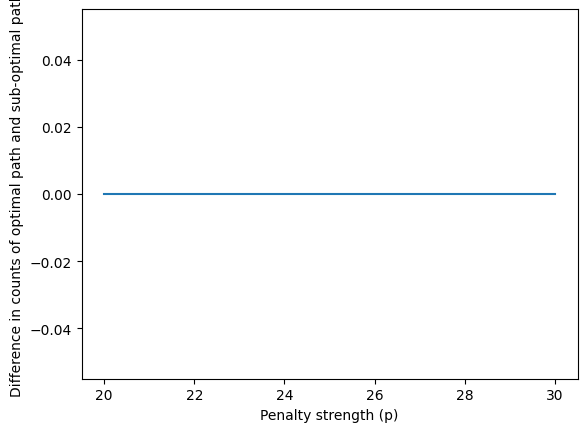

{20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0}


In [94]:
p_min, p_max = 20, 30
def test2(G, edges, weights, source, destination, nodes, p_min, p_max):
    p_array = list(range(p_min,p_max+1))
    count_diff_array = []
    for p in p_array:
        max_count_string = Static_Model(G, edges, weights, source, destination, nodes, p)[1]
        max_count = int(max_count_string)
        max2_count_string = Static_Model(G, edges, weights, source, destination, nodes, p)[3]
        max2_count = int(max_count_string)
        count_diff = max_count - max2_count
        count_diff_array.append(count_diff)
    plt.plot(p_array, count_diff_array)
    plt.xlabel('Penalty strength (p)')
    plt.ylabel('Difference in counts of optimal path and sub-optimal path')
    plt.show()
    result_dict = {}
    for i in range(len(p_array)):
        result_dict[p_array[i]] = count_diff_array[i]
    return result_dict
result_dict = test2(G, edges, weights, source, destination, nodes, p_min, p_max)
print(result_dict)

# Error Mitigation #
we get two options in hand: 1) Mitiq 2) Parity QAOA

# Dwave Quantum Annealing #

In [21]:
#Carrying out annealing using dwave-neal

def anneal(model):
 import neal
 sampler = neal.SimulatedAnnealingSampler()
 bqm = model.to_bqm()
 sampleset = sampler.sample(bqm, num_reads=10)
 decoded_samples = model.decode_sampleset(sampleset)
 best_sample = min(decoded_samples, key=lambda x: x.energy)
 return best_sample.sample

res_neal = anneal(model)
print(res_neal)

{'x[0]': 1, 'x[1]': 0, 'x[2]': 1, 'x[3]': 0, 'x[4]': 1}
